In [1]:
import nest_asyncio
nest_asyncio.apply()

This notebook gives an example of federated learning with bias. First, we set up our environment and load the data. We'll use the EMNIST dataset. This splits up the MNIST dataset by client (i.e. the person who wrote the samples). There are 3383 clients in this dataset. 

The federated learning implementation follows the tutorial at https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification.
I have added the bias demonstration myself. 

In [29]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
np.random.seed(0)

In [3]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [4]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [5]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)

In [6]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [10]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))
evaluation = tff.learning.build_federated_evaluation(model_fn)

First, let's train with no bias, to get a decent baseline:

In [99]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)
federated_test_data = make_federated_data(emnist_test, sample_clients)

state = iterative_process.initialize()

training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

NUM_ROUNDS = 40
for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    train_data = evaluation(state.model, federated_train_data)
    training_loss.append(train_data['eval']['loss'])
    training_acc.append(train_data['eval']['sparse_categorical_accuracy'])
    val_data = evaluation(state.model, federated_test_data)
    val_loss = val_data['eval']['loss']
    val_accuracy = val_data['eval']['sparse_categorical_accuracy']
    validation_loss.append(val_loss)
    validation_acc.append(val_accuracy)
    print('round {:2d}, training_loss={}, train_accuracy={}, validation_loss={}, validation_accuracy={}'.format(round_num, train_data['eval']['loss'], train_data['eval']['sparse_categorical_accuracy'], val_loss, val_accuracy))
    # print(evaluation(state.model, federated_test_data))

[libprotobuf INFO google/protobuf/util/message_differencer.cc:1419] Proto type 'tensorflow.GraphDef' not found


round  1, training_loss=2.4110262393951416, train_accuracy=0.13991770148277283, validation_loss=2.4211435317993164, validation_accuracy=0.13793103396892548
round  2, training_loss=2.17671537399292, train_accuracy=0.15329217910766602, validation_loss=2.2611300945281982, validation_accuracy=0.09482758492231369
round  3, training_loss=2.1730570793151855, train_accuracy=0.16769547760486603, validation_loss=2.1771864891052246, validation_accuracy=0.1465517282485962
round  4, training_loss=1.9612047672271729, train_accuracy=0.39403292536735535, validation_loss=2.0145325660705566, validation_accuracy=0.42241379618644714
round  5, training_loss=1.9371957778930664, train_accuracy=0.4444444477558136, validation_loss=1.9344642162322998, validation_accuracy=0.4655172526836395
round  6, training_loss=2.013984441757202, train_accuracy=0.20576131343841553, validation_loss=2.0544581413269043, validation_accuracy=0.1551724076271057
round  7, training_loss=1.8545610904693604, train_accuracy=0.2325102835

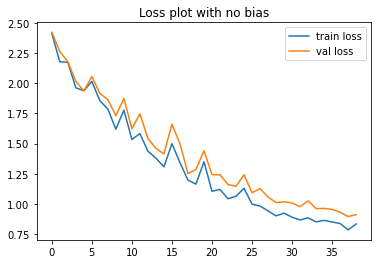

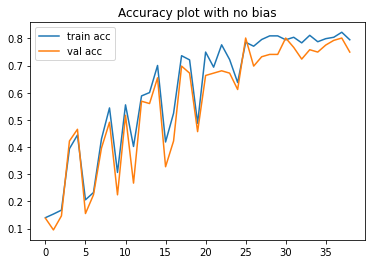

In [ ]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Loss plot with no bias')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(training_acc)
plt.plot(validation_acc)
plt.title('Accuracy plot with no bias')
plt.legend(['train acc', 'val acc'])
plt.show()

Now we add some bias. In this case, we are going to make an incorrect assumption that there are 9 valid values for the data instead of 10. 

In [93]:
def preprocess_with_bias(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))

    # Remove element 9 from the dataset. Every "9" will show up with label 0.
    def add_bias(element):
        y = element['y']
        y = y % 9
        
        return collections.OrderedDict(
            x=element['x'],
            y=y)

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).map(add_bias).prefetch(PREFETCH_BUFFER)

def make_biased_federated_data(client_data, client_ids):
  return [
      preprocess_with_bias(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
biased_example_dataset = preprocess_with_bias(example_dataset)
print(next(iter(biased_example_dataset)))

biased_federated_train_data = make_biased_federated_data(emnist_train, sample_clients)

OrderedDict([('x', <tf.Tensor: shape=(20, 784), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>), ('y', <tf.Tensor: shape=(20, 1), dtype=int32, numpy=
array([[2],
       [1],
       [5],
       [7],
       [1],
       [7],
       [7],
       [1],
       [4],
       [7],
       [4],
       [2],
       [2],
       [5],
       [4],
       [1],
       [1],
       [0],
       [0],
       [0]], dtype=int32)>)])


In [101]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))
evaluation = tff.learning.build_federated_evaluation(model_fn)

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_biased_federated_data(emnist_train, sample_clients)
federated_test_data = make_federated_data(emnist_test, sample_clients)

state = iterative_process.initialize()

training_loss_bias = []
validation_loss_bias = []
training_acc_bias = []
validation_acc_bias = []

NUM_ROUNDS = 40
for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    train_data = evaluation(state.model, federated_train_data)
    training_loss_bias.append(train_data['eval']['loss'])
    training_acc_bias.append(train_data['eval']['sparse_categorical_accuracy'])
    val_data = evaluation(state.model, federated_test_data)
    val_loss = val_data['eval']['loss']
    val_accuracy = val_data['eval']['sparse_categorical_accuracy']
    validation_loss_bias.append(val_loss)
    validation_acc_bias.append(val_accuracy)
    print('round {:2d}, training_loss={}, train_accuracy={}, validation_loss={}, validation_accuracy={}'.format(round_num, train_data['eval']['loss'], train_data['eval']['sparse_categorical_accuracy'], val_loss, val_accuracy))


[libprotobuf INFO google/protobuf/util/message_differencer.cc:1419] Proto type 'tensorflow.GraphDef' not found


round  1, training_loss=2.4389655590057373, train_accuracy=0.1039094626903534, validation_loss=2.8168904781341553, validation_accuracy=0.12068965286016464
round  2, training_loss=2.2610652446746826, train_accuracy=0.37037035822868347, validation_loss=2.658719062805176, validation_accuracy=0.2844827473163605
round  3, training_loss=2.210686683654785, train_accuracy=0.13477365672588348, validation_loss=2.6835849285125732, validation_accuracy=0.12931033968925476
round  4, training_loss=2.0474321842193604, train_accuracy=0.375514417886734, validation_loss=2.5552308559417725, validation_accuracy=0.32758620381355286
round  5, training_loss=1.8263330459594727, train_accuracy=0.19855967164039612, validation_loss=2.535142421722412, validation_accuracy=0.12068965286016464
round  6, training_loss=1.9185502529144287, train_accuracy=0.2674897015094757, validation_loss=2.684601306915283, validation_accuracy=0.18103447556495667
round  7, training_loss=1.8893154859542847, train_accuracy=0.146090537309

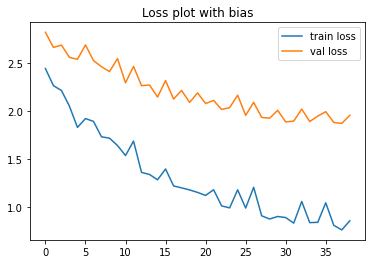

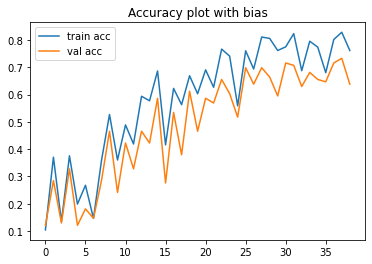

In [102]:
plt.plot(training_loss_bias)
plt.plot(validation_loss_bias)
plt.title('Loss plot with bias')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(training_acc_bias)
plt.plot(validation_acc_bias)
plt.title('Accuracy plot with bias')
plt.legend(['train acc', 'val acc'])
plt.show()

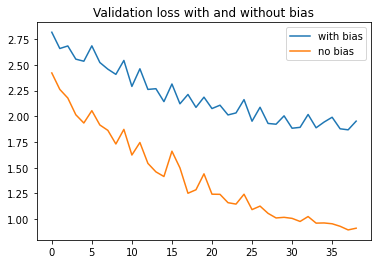

In [106]:
plt.title('Validation loss with and without bias')
plt.plot(validation_loss_bias)
plt.plot(validation_loss)
plt.legend(['with bias', 'no bias'])
plt.show()

Next, suppose we start training our federated model, but we quickly recover after, say, 10 epochs:

In [107]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

unbiased_train_data = make_federated_data(emnist_train, sample_clients)
biased_train_data = make_biased_federated_data(emnist_train, sample_clients)
federated_test_data = make_federated_data(emnist_test, sample_clients)

state = iterative_process.initialize()

training_loss_recover = []
validation_loss_recover = []
training_acc_recover = []
validation_acc_recover = []

train_dataset = biased_train_data

NUM_ROUNDS = 40
for round_num in range(1, NUM_ROUNDS):
    if round_num == 10:
        # Fix the bias
        train_dataset = unbiased_train_data
    state, metrics = iterative_process.next(state, train_dataset)
    train_data = evaluation(state.model, train_dataset)
    training_loss_recover.append(train_data['eval']['loss'])
    training_acc_recover.append(train_data['eval']['sparse_categorical_accuracy'])
    val_data = evaluation(state.model, federated_test_data)
    val_loss = val_data['eval']['loss']
    val_accuracy = val_data['eval']['sparse_categorical_accuracy']
    validation_loss_recover.append(val_loss)
    validation_acc_recover.append(val_accuracy)
    print('round {:2d}, training_loss={}, train_accuracy={}, validation_loss={}, validation_accuracy={}'.format(round_num, train_data['eval']['loss'], train_data['eval']['sparse_categorical_accuracy'], val_loss, val_accuracy))


[libprotobuf INFO google/protobuf/util/message_differencer.cc:1419] Proto type 'tensorflow.GraphDef' not found


round  1, training_loss=2.4389657974243164, train_accuracy=0.1039094626903534, validation_loss=2.8168907165527344, validation_accuracy=0.12068965286016464
round  2, training_loss=2.2610690593719482, train_accuracy=0.37037035822868347, validation_loss=2.658719301223755, validation_accuracy=0.2844827473163605
round  3, training_loss=2.210674285888672, train_accuracy=0.13477365672588348, validation_loss=2.683577299118042, validation_accuracy=0.12931033968925476
round  4, training_loss=2.0478522777557373, train_accuracy=0.375514417886734, validation_loss=2.555405378341675, validation_accuracy=0.32758620381355286
round  5, training_loss=1.8268462419509888, train_accuracy=0.19855967164039612, validation_loss=2.5359714031219482, validation_accuracy=0.12068965286016464
round  6, training_loss=1.912782073020935, train_accuracy=0.26954731345176697, validation_loss=2.6746511459350586, validation_accuracy=0.17241379618644714
round  7, training_loss=1.8864892721176147, train_accuracy=0.147119343280

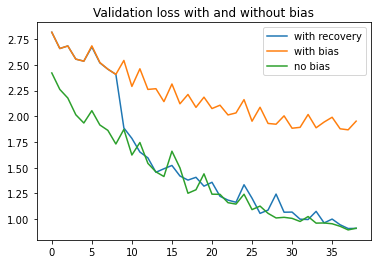

In [108]:
plt.title('Validation loss with and without bias')
plt.plot(validation_loss_recover)
plt.plot(validation_loss_bias)
plt.plot(validation_loss)
plt.legend(['with recovery', 'with bias', 'no bias'])
plt.show()

So it's evident that quickly catching the bias will lead to a significant recovery in the model's performance. The FedGAN (implemented in the other notebook) helps to detect such biases.